# Übung zu: Kontextsensitive Systeme

In [19]:
#import libs 
import pandas as pd
import matplotlib.pyplot as plt
import glob

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

from sklearn_porter import Porter

In [20]:
# read data & show first few lines
dataFrames = []
#filenames = glob.glob("newdata/*.txt")csvData (1)_010003.txt
filenames = glob.glob("newdata/*")

for file in filenames:
    print(file)
    newDataFrame = pd.read_csv(file, sep=';', decimal=".", index_col=2)
    newDataFrame.index = pd.to_datetime(newDataFrame.index, unit='ms')
    dataFrames.append(newDataFrame)

# combine all files
data = pd.concat(dataFrames)

# make subject id string format
data['sampleId'] = data['sampleId'].astype(str)

# show first few lines
data.head()

newdata\csvData (1)_010003.txt
newdata\csvData (1)_010022.txt
newdata\csvData (1)_010044.txt
newdata\csvData (1)_125920.txt
newdata\csvData (1)_125941.txt
newdata\csvData (2)_011444.txt
newdata\csvData (2)_011500.txt
newdata\csvData (2)_011511.txt
newdata\csvData (2)_011522.txt
newdata\csvData (2)_011533.txt
newdata\csvData_table (1).txt
newdata\csvData_table (2).txt
newdata\csvData_table (3).txt
newdata\csvData_table (4).txt
newdata\csvData_table (5).txt


,activity,sampleId,alpha,beta,gamma,x,y,z
stamp,,,,,,,,
2021-11-04 11:51:23.670,stand,Id3,315.0,37.5,3.8,-0.1,0.1,-0.5
2021-11-04 11:51:23.713,stand,Id3,314.9,37.6,3.8,0.0,-0.1,-0.1
2021-11-04 11:51:23.729,stand,Id3,314.8,37.7,3.9,0.0,0.0,-0.1
2021-11-04 11:51:23.736,stand,Id3,314.8,37.7,3.9,0.0,0.0,-0.1
2021-11-04 11:51:23.755,stand,Id3,314.8,37.7,3.9,0.1,0.0,0.0


In [21]:
# create windows

# choose features to calc
features = ['min', 'max', 'median', 'std']

# aggregate data with features
# Explained here: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html
aggregated_frame = data.drop(['sampleId', 'activity'], axis=1).groupby(pd.Grouper(freq='3000ms')).aggregate(features).dropna()

# create a new dataframe with re-labled columns (& 1d columns)
aggregated_frame_1d = aggregated_frame.copy()
aggregated_frame_1d.columns = [col[0] + "_" + col[1] for col in aggregated_frame_1d.columns]

# create new dataframe with re-added old labels
aggregated_strings = data[['sampleId', 'activity']].groupby(pd.Grouper(freq='3000ms')).first()
aggregated_frame_1d_withLabels = aggregated_frame_1d.join(aggregated_strings)


In [22]:
#aggregated_frame_1d_withLabels.head()

# Training

In [23]:
# split the data into target label and depending variables
y = aggregated_frame_1d_withLabels["activity"]
X = aggregated_frame_1d_withLabels.drop(["sampleId", "activity"], axis=1)


In [24]:
y.head()

stamp
2021-11-04 10:31:24    table
2021-11-04 10:31:27    table
2021-11-04 10:31:30    table
2021-11-04 10:31:33    table
2021-11-04 10:31:36    table
Name: activity, dtype: object

In [25]:
X.head()

,alpha_min,alpha_max,alpha_median,alpha_std,beta_min,beta_max,beta_median,beta_std,gamma_min,gamma_max,...,x_median,x_std,y_min,y_max,y_median,y_std,z_min,z_max,z_median,z_std
stamp,,,,,,,,,,,,,,,,,,,,,
2021-11-04 10:31:24,0.0,270.3,270.0,107.648409,0.2,0.8,0.6,0.218627,-0.5,-0.2,...,0.0,0.002895,0.0,0.0,0.0,0.000000,0.0,0.1,0.0,0.039852
2021-11-04 10:31:27,0.0,270.3,270.0,131.331295,0.2,0.8,0.5,0.201729,-0.6,-0.2,...,0.0,0.001805,0.0,0.0,0.0,0.000000,0.0,0.1,0.0,0.040581
2021-11-04 10:31:30,0.0,270.3,270.0,131.522202,0.2,0.8,0.5,0.197536,-0.6,0.1,...,0.0,0.004036,0.0,0.1,0.0,0.001805,-0.2,0.2,0.0,0.038938
2021-11-04 10:31:33,0.0,270.3,270.0,131.662991,0.2,0.8,0.5,0.197851,-0.6,-0.2,...,0.0,0.002606,-0.2,0.2,0.0,0.008444,-0.2,0.3,0.0,0.040184
2021-11-04 10:31:36,0.0,270.3,270.0,132.247165,0.2,0.8,0.5,0.199440,-0.6,-0.2,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.1,0.0,0.039642


In [26]:
names = [
        "Nearest Neighbors", 
        "RBF SVM",
        "Linear SVM (via kernel)",
        "Linear SVM (native)",
        "SVM (rbf kernel)"
        "Decision Tree", 
        "Random Forest", 
        "Naive Bayes"
]

classifiers = [
    KNeighborsClassifier(10),
    SVC(kernel="rbf", C=1.0, gamma="auto", random_state=0),
    SVC(kernel="linear", C=1.0, random_state=0),
    LinearSVC(random_state=0, max_iter=10000),
    DecisionTreeClassifier(max_depth=12, random_state=0),
    RandomForestClassifier(max_depth=23, n_estimators=10, random_state=0),
    GaussianNB()
]

column_names = list(X.columns)
X_scaled = StandardScaler().fit_transform(X)

In [27]:
def evaluate(clfs, names, splits, X, y, silent=False):
    scores = np.zeros((len(splits), len(classifiers)))
    confusions = [None] * len(classifiers)
    
    # Iterate over every split
    for split_idx, (train_index, test_index) in tqdm(enumerate(splits), total=len(splits), disable=silent):
        y_train, y_test = y[train_index], y[test_index]
        X_train, X_test = X[train_index], X[test_index]

        # Iterate over every classifier
        for clf_idx, (name, clf) in enumerate(zip(names, clfs)):
            clf.fit(X_train, y_train)
            cm = confusion_matrix(y_test, clf.predict(X_test), ['table','stand','walk'])
            if confusions[clf_idx] is None:
                confusions[clf_idx] = cm
            else:
                confusions[clf_idx] = confusions[clf_idx] + cm
            scores[split_idx, clf_idx] = clf.score(X_test, y_test)
    return np.mean(scores, axis=0), np.std(scores, axis=0), confusions

def printStatistics(names, mean_accuracies, std_accuracies, confusions):
    for name, mean_accuracy, std_accuracy, confusion in zip(names, mean_accuracies, std_accuracies, confusions):
        print(name)
        print('Mean accuracy:', mean_accuracy)
        print('Std accuracy:', std_accuracy)
        print('Confusion Matrix:')
        print(['table','stand','walk'])
        print(confusion)
        print("\n")    

In [28]:
# replace subjectlabels with numbers to group them
i = 0
for id_str in aggregated_frame_1d_withLabels["sampleId"].unique().tolist():
    id_str = str(id_str)
    i_str = str(i)
    aggregated_frame_1d_withLabels["sampleId"] = aggregated_frame_1d_withLabels["sampleId"].str.replace(id_str,i_str)
    i += 1

In [29]:
aggregated_frame_1d_withLabels.head()

,alpha_min,alpha_max,alpha_median,alpha_std,beta_min,beta_max,beta_median,beta_std,gamma_min,gamma_max,...,y_min,y_max,y_median,y_std,z_min,z_max,z_median,z_std,sampleId,activity
stamp,,,,,,,,,,,,,,,,,,,,,
2021-11-04 10:31:24,0.0,270.3,270.0,107.648409,0.2,0.8,0.6,0.218627,-0.5,-0.2,...,0.0,0.0,0.0,0.000000,0.0,0.1,0.0,0.039852,0,table
2021-11-04 10:31:27,0.0,270.3,270.0,131.331295,0.2,0.8,0.5,0.201729,-0.6,-0.2,...,0.0,0.0,0.0,0.000000,0.0,0.1,0.0,0.040581,1,table
2021-11-04 10:31:30,0.0,270.3,270.0,131.522202,0.2,0.8,0.5,0.197536,-0.6,0.1,...,0.0,0.1,0.0,0.001805,-0.2,0.2,0.0,0.038938,1,table
2021-11-04 10:31:33,0.0,270.3,270.0,131.662991,0.2,0.8,0.5,0.197851,-0.6,-0.2,...,-0.2,0.2,0.0,0.008444,-0.2,0.3,0.0,0.040184,2,table
2021-11-04 10:31:36,0.0,270.3,270.0,132.247165,0.2,0.8,0.5,0.199440,-0.6,-0.2,...,0.0,0.0,0.0,0.000000,0.0,0.1,0.0,0.039642,5,table


In [30]:
splits = list(LeaveOneGroupOut().split(X, y, groups=aggregated_frame_1d_withLabels["sampleId"]))

#print(splits)

mean_accuracies, std_accuracies, confusions = evaluate(classifiers, names, splits, X_scaled, y, silent=True)
printStatistics(names, mean_accuracies, std_accuracies, confusions)

Nearest Neighbors
Mean accuracy: 0.9851248811684383
Std accuracy: 0.02054026300375135
Confusion Matrix:
['table', 'stand', 'walk']
[[102   0   0]
 [  2 100   0]
 [  0   4  98]]


RBF SVM
Mean accuracy: 0.9927188661308443
Std accuracy: 0.013727892468203003
Confusion Matrix:
['table', 'stand', 'walk']
[[102   0   0]
 [  0 102   0]
 [  0   4  98]]


Linear SVM (via kernel)
Mean accuracy: 0.9945985653789646
Std accuracy: 0.009414351908408239
Confusion Matrix:
['table', 'stand', 'walk']
[[102   0   0]
 [  0 101   1]
 [  0   2 100]]


Linear SVM (native)
Mean accuracy: 0.9861952040344268
Std accuracy: 0.020531646290000007
Confusion Matrix:
['table', 'stand', 'walk']
[[102   0   0]
 [  0 101   1]
 [  0   4  98]]


SVM (rbf kernel)Decision Tree
Mean accuracy: 0.9849954500856605
Std accuracy: 0.01922665848380305
Confusion Matrix:
['table', 'stand', 'walk']
[[102   0   0]
 [  0  98   4]
 [  0   3  99]]


Random Forest
Mean accuracy: 0.990839166882724
Std accuracy: 0.018184588874713338
Confusion 

In [31]:
# 10-Fold Cross-Validation
splits = list(KFold(n_splits=10, shuffle=True).split(X, y))

mean_accuracies, std_accuracies, confusions = evaluate(classifiers, names, splits, X_scaled, y, silent=True)
printStatistics(names, mean_accuracies, std_accuracies, confusions)

Nearest Neighbors
Mean accuracy: 0.983763440860215
Std accuracy: 0.026075878498581256
Confusion Matrix:
['table', 'stand', 'walk']
[[102   0   0]
 [  1 101   0]
 [  0   4  98]]


RBF SVM
Mean accuracy: 0.9869892473118279
Std accuracy: 0.02149704139554341
Confusion Matrix:
['table', 'stand', 'walk']
[[102   0   0]
 [  0 102   0]
 [  0   4  98]]


Linear SVM (via kernel)
Mean accuracy: 0.9902150537634409
Std accuracy: 0.014949330537656413
Confusion Matrix:
['table', 'stand', 'walk']
[[102   0   0]
 [  0 101   1]
 [  0   2 100]]


Linear SVM (native)
Mean accuracy: 0.9902150537634409
Std accuracy: 0.014949330537656413
Confusion Matrix:
['table', 'stand', 'walk']
[[102   0   0]
 [  0 102   0]
 [  0   3  99]]


SVM (rbf kernel)Decision Tree
Mean accuracy: 0.9772043010752688
Std accuracy: 0.0291070323412513
Confusion Matrix:
['table', 'stand', 'walk']
[[102   0   0]
 [  0  97   5]
 [  0   2 100]]


Random Forest
Mean accuracy: 0.9902150537634409
Std accuracy: 0.014949330537656413
Confusion M

In [32]:
# Recursive Feature Elimination

clf = RandomForestClassifier(max_depth=10, n_estimators=50, max_features=2, random_state=0, bootstrap=True)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

[Text(478.2857142857143, 1009.5428571428572, 'beta_median <= 5.35\ngini = 0.666\nsamples = 189\nvalue = [110, 97, 99]\nclass = table'),
 Text(239.14285714285714, 854.2285714285715, 'gini = 0.0\nsamples = 59\nvalue = [0, 97, 0]\nclass = stand'),
 Text(717.4285714285714, 854.2285714285715, 'z_std <= 0.669\ngini = 0.499\nsamples = 130\nvalue = [110, 0, 99]\nclass = table'),
 Text(478.2857142857143, 698.9142857142858, 'gini = 0.0\nsamples = 65\nvalue = [108, 0, 0]\nclass = table'),
 Text(956.5714285714286, 698.9142857142858, 'x_median <= -0.05\ngini = 0.039\nsamples = 65\nvalue = [2, 0, 99]\nclass = walk'),
 Text(717.4285714285714, 543.6, 'gini = 0.0\nsamples = 37\nvalue = [0, 0, 62]\nclass = walk'),
 Text(1195.7142857142858, 543.6, 'beta_min <= 44.65\ngini = 0.097\nsamples = 28\nvalue = [2, 0, 37]\nclass = walk'),
 Text(956.5714285714286, 388.28571428571433, 'y_max <= 2.15\ngini = 0.051\nsamples = 27\nvalue = [1, 0, 37]\nclass = walk'),
 Text(717.4285714285714, 232.97142857142865, 'gamma_

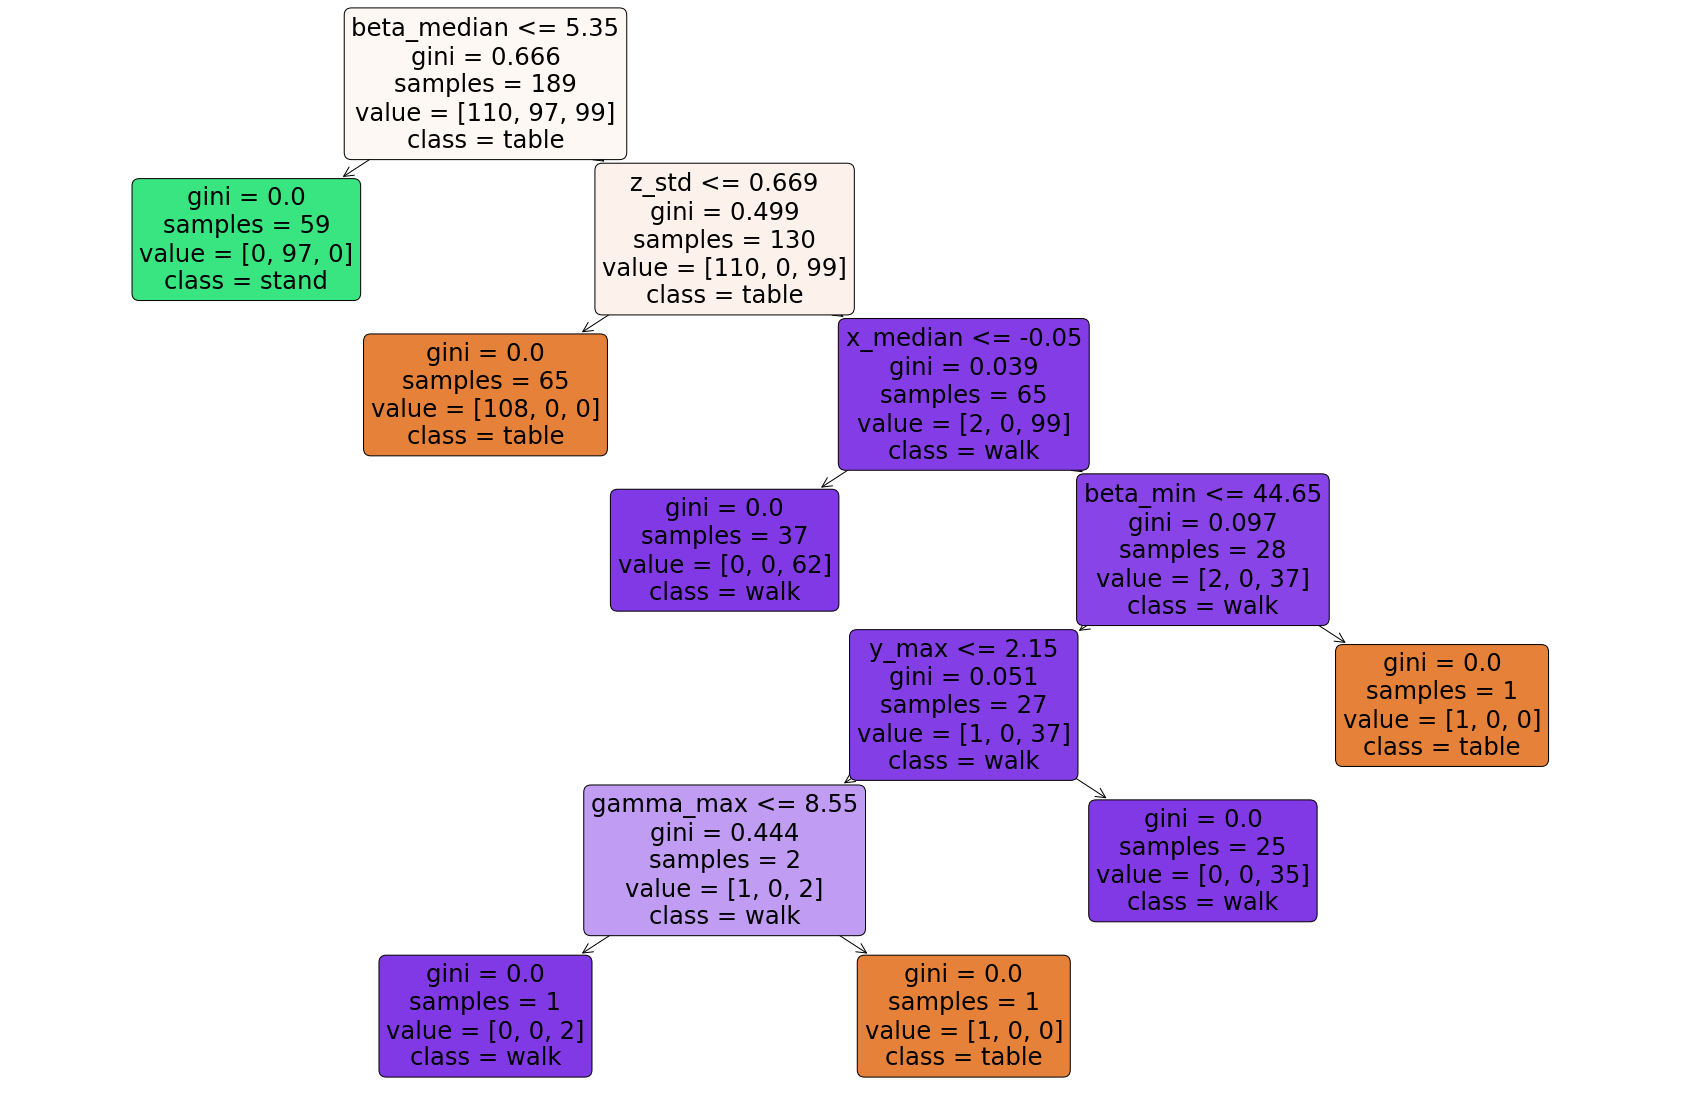

In [33]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(30, 20))
plot_tree(clf.estimators_[0],
        feature_names=X.columns,
        class_names=['table', 'stand', 'walk'],
        filled=True, impurity=True,
        rounded=True)

In [34]:
##names = [
##  0      "Nearest Neighbors", 
##  1      "RBF SVM",
##  2      "Linear SVM (via kernel)",
##  3      "Linear SVM (native)",
##  4       "SVM (rbf kernel)"
##  5      "Decision Tree", 
##  6      "Random Forest", 
##  7      "Naive Bayes"
##


# create the model
porter = Porter(clf, language='js')
export = porter.export(embed_data=True)

# save the model
f = open("model.js", "w")
f.write(export)
f.close()